# Noise_study
Goal : This Notebook will generate plots allowing to perform a diagnostic on the noise ( correlation between channels and FFT ) .

Author : P.Antilogus

Version : 4th July 2019 14:25 

New : compatible with raft data at NCSA


In [1]:
# CONFIGURATION FOR THE CURRENT EXECUTION  ========================================
# ---- raft and associated run ============ To be updated if needed 
# 'RTM' :  full RTM name 
# 'Data_location'  :  0 = BNL_RAFT_ROOT ,  1 = SLAC_RAFT_ROOT 
# 'run' :  list of run , ex : ['9876','9874']  (remark : run is a string )   for all run of this raft : '*' 
# 'sensor' :  list of sensor , ex ['S00','S01','S02']  ,  for all sensor ['S*']
# amplifier : list of amplifier , ex [1,2]  , for 1 to 16 you can use [-1] instead 
data_to_select={'RTM':'RTM-004','Data_location':4,'run':['10103'],'sensor':['S*'],'amplifier':[-1]}
# The code take the bias assocaited to the dark run , we can eather take 1 bias per run ( fast ) , or all ( ~ 5 time slower but more precise plots ) 
multi_bias=True
# bais can be taken from # process , don't use the one with light , it makes bias "unstable" 
# good option are 'dark_raft_acq' or 'fe55_raft_acq'  but in eotest the last one has only 1 bias per run 
bias_dir='dark_raft_acq'


In [2]:
count =!set | grep  .ncsa.illinois.edu | wc
if int(count[0].split()[0])> 1 : 
    NCSA=True
else : 
    NCSA=False
if NCSA : 
    SLACmirror='/project/rgruendl/SLACmirror'
    # 0) the list of super flat for a raft - run : BNL_RAFT_ROOT+raft+'/'+run+'/cte_raft/*/*/'+'Sxx'+'/*_superflat_high.fits' 
    BNL_RAFT_ROOT=SLACmirror+'/BNLmirror/mirror/BNL-prod/prod/LCA-11021_RTM/LCA-11021_'
    # 1)
    SLAC_RAFT_ROOT=SLACmirror+'/SLACgpfs/jh_archive/LCA-11021_RTM/LCA-11021_'
    # 2) Remark the raft name in general have a -Dev attahed to them for this SLAC dev sample 
    BNL_DEV_RAFT_ROOT=SLACmirror+'/BNLmirror/mirror/BNL-test/test/LCA-11021_RTM/LCA-11021_'
    # 3) 
    SLAC_DEV_RAFT_ROOT=SLACmirror+'/SLACgpfs/jh_archive-test/LCA-11021_RTM/LCA-11021_'
    # 4) 
    SLAC_fs3_RAFT_ROOT=SLACmirror+'/fs3/jh_archive/LCA-11021_RTM/LCA-11021_'
    # 5) 
    SLAC_DEV_fs3_RAFT_ROOT=SLACmirror+'/fs3/jh_archive-test/LCA-11021_RTM/LCA-11021_'
    # other can be used if needed (including NCSA directory ) , 
    # then just the order in which they are added to RAFT_ROOT should follow what will be given to 'data_location' 
    ROOT=[BNL_RAFT_ROOT,SLAC_RAFT_ROOT,BNL_DEV_RAFT_ROOT,SLAC_DEV_RAFT_ROOT,SLAC_fs3_RAFT_ROOT,SLAC_DEV_fs3_RAFT_ROOT]
else :
    # 0) the list of super flat for a raft - run : BNL_RAFT_ROOT+raft+'/'+run+'/cte_raft/*/*/'+'Sxx'+'/*_superflat_high.fits' 
    BNL_RAFT_ROOT='/nfs/farm/g/lsst/u1/mirror/BNL-prod/prod/LCA-11021_RTM/LCA-11021_'
    # 1)
    SLAC_RAFT_ROOT='/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_'
    # 2) Remark the raft name in general have a -Dev attahed to them for this SLAC dev sample 
    BNL_DEV_RAFT_ROOT='/nfs/farm/g/lsst/u1/mirror/BNL-test/test/LCA-11021_RTM/LCA-11021_'
    # 3) 
    SLAC_DEV_RAFT_ROOT='/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive-test/LCA-11021_RTM/LCA-11021_'
    # 4) 
    SLAC_fs3_RAFT_ROOT='/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_'
    # 5) 
    SLAC_DEV_fs3_RAFT_ROOT='/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive-test/LCA-11021_RTM/LCA-11021_'
    # other can be used if needed (including NCSA directory ) , 
    # then just the order in which they are added to RAFT_ROOT should follow what will be given to 'data_location' 
    ROOT=[BNL_RAFT_ROOT,SLAC_RAFT_ROOT,BNL_DEV_RAFT_ROOT,SLAC_DEV_RAFT_ROOT,SLAC_fs3_RAFT_ROOT,SLAC_DEV_fs3_RAFT_ROOT]
    
# For each directory tree in which part of the eotest DB can we get the associated data ( used for the gain )
DB_key=['Prod','Prod','Dev','Dev','Prod','Dev']

In [3]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as pyfits
import matplotlib
import time
%matplotlib inline
%run -i  ../../python/lsst/eochar/frame_study.py

In [4]:
# how many run & sensor 
sensor_dir=[]
run_loc=[]
# get all directory  for all sensor and all run 
for run_cur in data_to_select['run'] :
    for sensor_cur  in data_to_select['sensor'] :
        root_dir=ROOT[data_to_select['Data_location']]+data_to_select['RTM']+'/'+run_cur+'/'+bias_dir+'/v0/*/'+sensor_cur
        run_loc+=glob.glob(root_dir)
# order them all 
run_loc.sort()
# filter : keep only 1 proceesing for a given run and sensor (the first seen )
run_name_list=[]
sensor_list=[]
sensor_all=[]
sensor_dir=[]
for run_cur in run_loc :
    name_list=run_cur.split('/')
    run_number=name_list[-5]
    if not(run_number in run_name_list ) :
        # new run , let see which sensor are in it 
        run_name_list.append(run_number)
        if len(sensor_all) > len(sensor_list) :
            sensor_list=sensor_all
        sensor_all=[]
    sensor_name=name_list[-1]
    if not(sensor_name in sensor_all) :
        sensor_all.append(sensor_name)
        # we keep the first processed data for this run and sensor
        sensor_dir.append({'dir':run_cur,'run':run_number,'sensor':sensor_name})
if len(sensor_all) > len(sensor_list) :
    sensor_list=sensor_all
sensor_list.sort()    
#
number_of_run=len(run_name_list)
number_of_sensor=len(sensor_list)
#
if number_of_run < 1 : 
    print('No data found for ',data_to_select)
    raise 
#
print('Noise study for ',number_of_run,' run(s) (',run_name_list,') from the raft ',data_to_select['RTM'])
#how many amplifiers 
if -1 in data_to_select['amplifier'] :
    amplifier_list=np.array(range(1,17))
else :
    amplifier_list=np.array(data_to_select['amplifier'])
amplifier_list.sort()
number_of_amplifier=len(amplifier_list)
if number_of_amplifier ==16 : 
    print('For the 16 amplifiers of ',number_of_sensor,' sensors (',sensor_list,')')
else :
    print('including ',number_of_sensor,' sensor(s) (',sensor_list,') and ',number_of_amplifier,'amplifier(s) (',amplifier_list,')')


Noise study for  1  run(s) ( ['10103'] ) from the raft  RTM-004
For the 16 amplifiers of  9  sensors ( ['S00', 'S01', 'S02', 'S10', 'S11', 'S12', 'S20', 'S21', 'S22'] )


For the first sensor and first run we selected  5  biases.
S00 processed, ~ 138  seconds left before the end of the processing of the run 10103
S01 processed, ~ 120  seconds left before the end of the processing of the run 10103
S02 processed, ~ 103  seconds left before the end of the processing of the run 10103
S10 processed, ~ 85  seconds left before the end of the processing of the run 10103
S11 processed, ~ 68  seconds left before the end of the processing of the run 10103
S12 processed, ~ 51  seconds left before the end of the processing of the run 10103
S20 processed, ~ 34  seconds left before the end of the processing of the run 10103
S21 processed, ~ 17  seconds left before the end of the processing of the run 10103


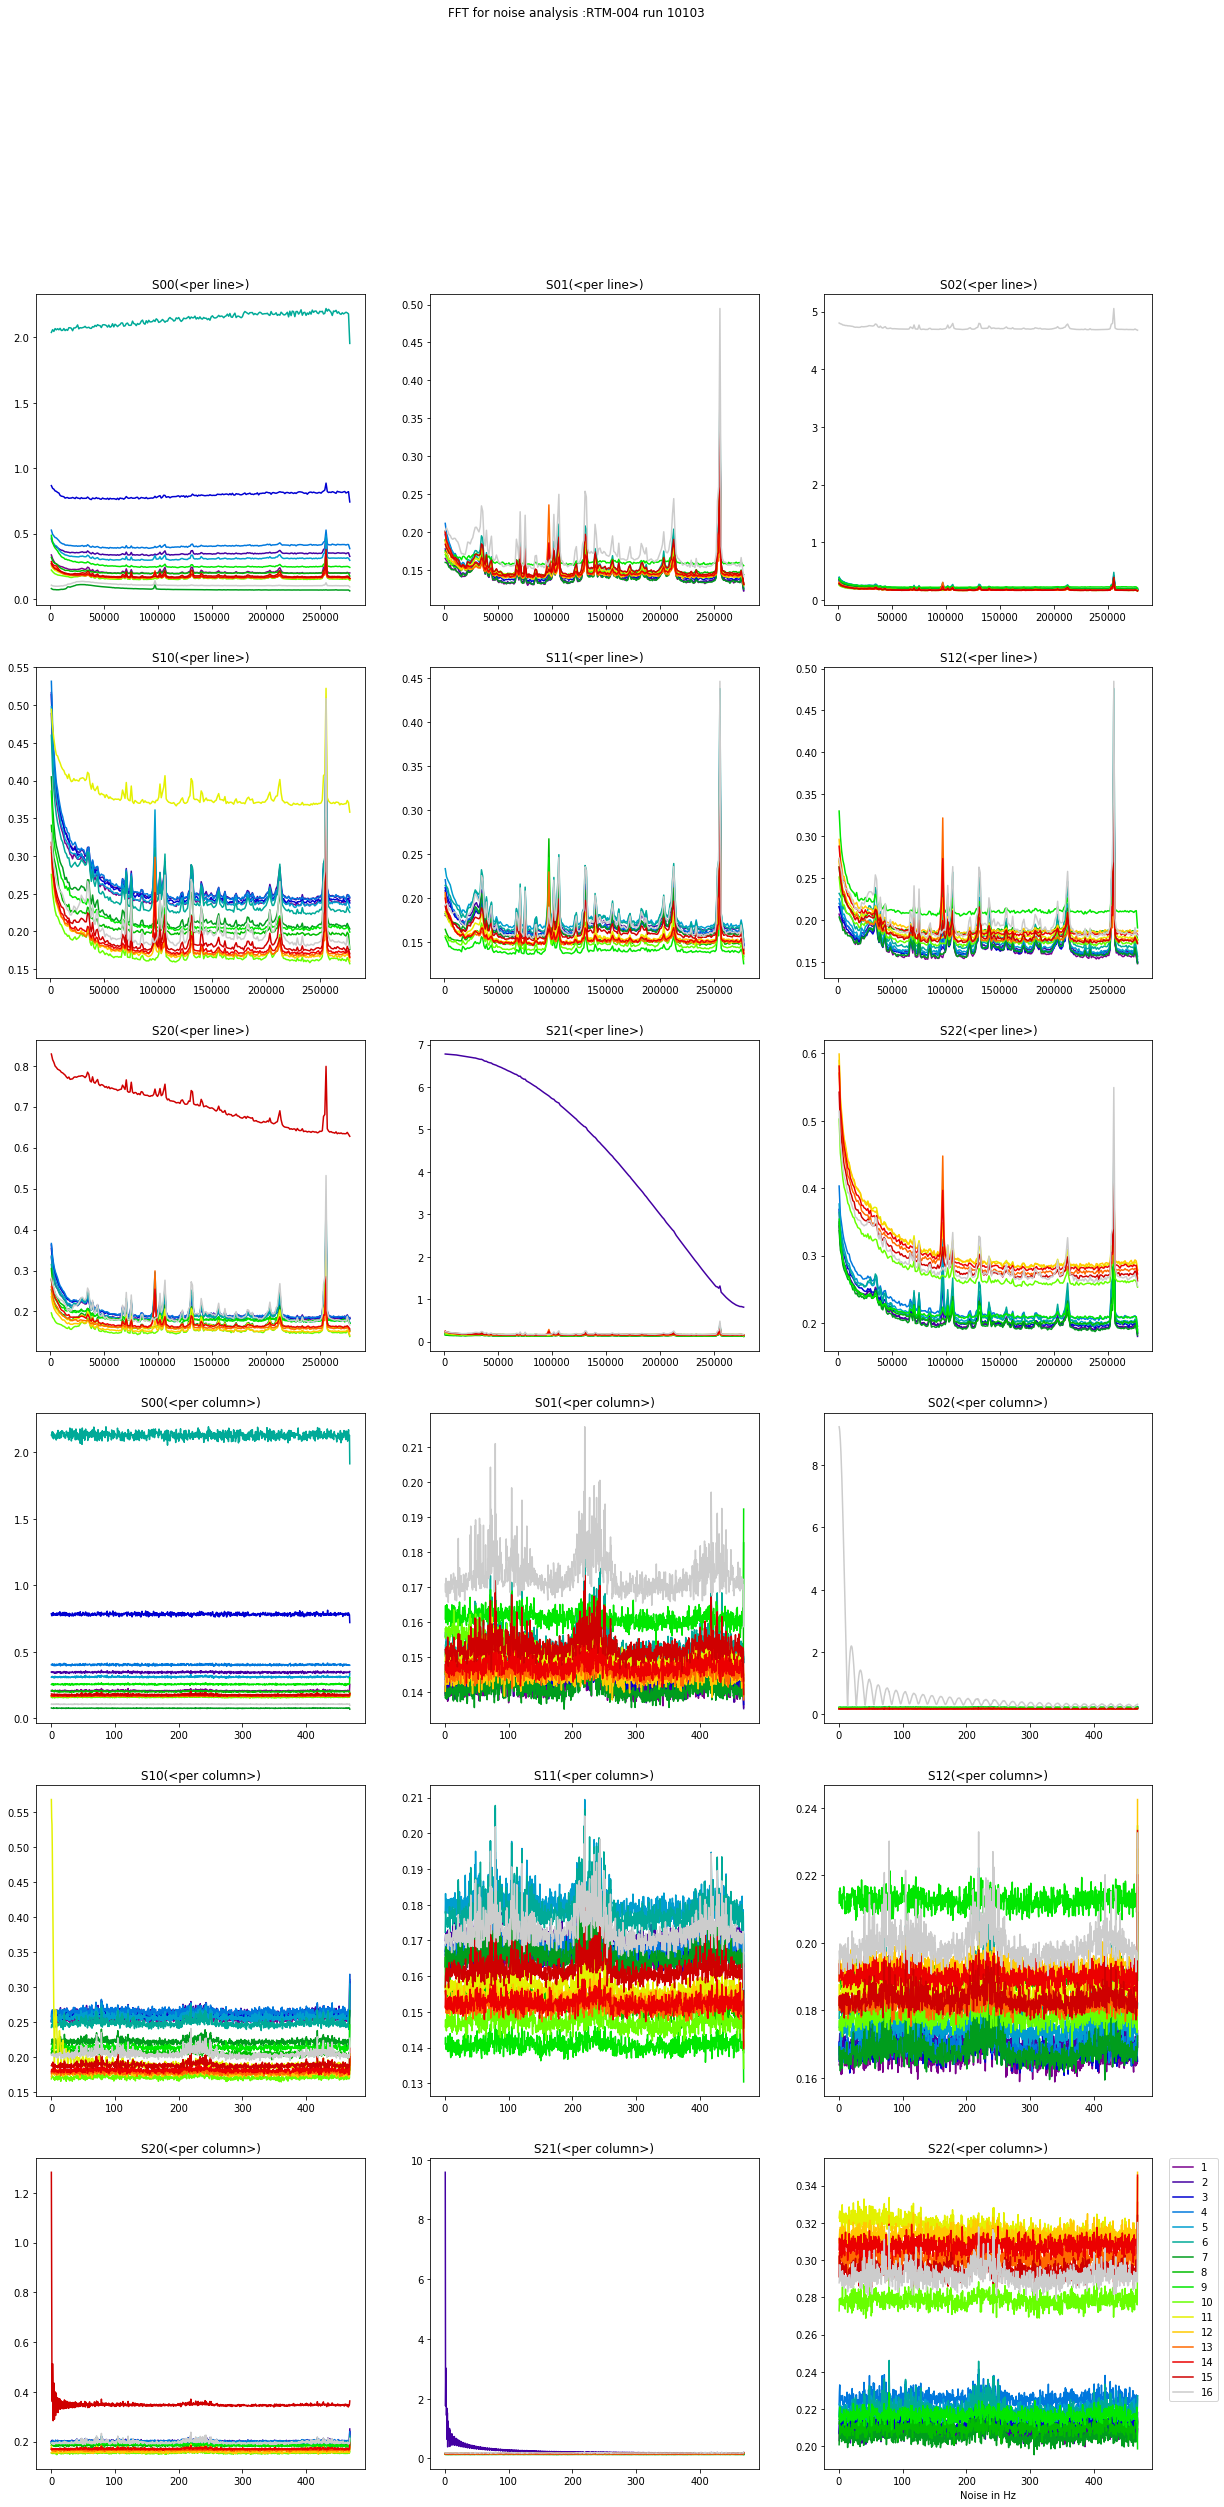

RTM-004_10103_fft_noise.png


In [5]:
# Do all the fft plots and compute the noise per image
# intialisation 
noise=np.zeros((number_of_run,number_of_sensor*16)) 
noise_std=np.zeros((number_of_run,number_of_sensor*16)) 
all_file=np.zeros((number_of_run,number_of_sensor),dtype=np.object_)
mean_over=np.zeros((number_of_run,144),dtype=np.object_)
run_seen=[]
t0=0
for dir_cur in sensor_dir : 
    irun=run_name_list.index(dir_cur['run'])
    if not (irun in run_seen ) :
        fig , axes = plt.subplots(6,3,figsize=[20,40]) 
        #fig.figsize=[20,20]
        axes1=np.ravel(axes)
        fig.suptitle('FFT for noise analysis :'+data_to_select['RTM']+' run '+run_name_list[irun])
        run_seen.append(irun)
    #
    iccd=sensor_list.index(dir_cur['sensor'])
    axes1[iccd].set_title(sensor_list[iccd]+'(<per line>)')
    axes1[iccd+9].set_title(sensor_list[iccd]+'(<per column>)')
    #
    file_list=glob.glob(dir_cur['dir']+'/*bias*.fits')
    file_list.sort()
    nb_bias=len(file_list) 
    if nb_bias < 1 : 
        print (data_to_select['RTM']+':'+sensor_list[iccd]+' no bias found')
        continue
    elif t0==0 : 
        t0=time.time()
        print ('For the first sensor and first run we selected ',nb_bias,' biases.')
    else :
        t1=time.time()
        print (sensor_list[iccd-1],'processed, ~',int((t1-t0)*(number_of_sensor-iccd)/iccd),' seconds left before the end of the processing of the run',run_name_list[irun])
    if not(multi_bias) :
        nb_bias=1
    file_cur=[]
    for ifile in range(nb_bias) :
        file_cur.append(pyfits.open(file_list[ifile]))
        if ifile == 0 : 
            # for the noise correlation between channels only the first bias of a serie will be used 
            all_file[irun,iccd]=np.copy(file_cur[0])
            if irun==0 : 
                first_line,first_p_over,first_col,first_s_over=image_area(file_cur[0])
                ncol=len(file_cur[0][1].data[100,:])
            for ch in range(16) :
                noise[irun,iccd*16+ch]=(file_cur[0][ch+1].data[100:1900,first_s_over+2:].std(axis=1)).mean()
                noise_std[irun,iccd*16+ch]=(file_cur[0][ch+1].data[100:1900,first_s_over+2:].std(axis=1)).std()/np.sqrt(1800)
    #
    if iccd==len(sensor_list)-1 :
        fft_noise(file_cur,channel=amplifier_list,fplot=True,mean=False,start=1,legend=True,two=True,axes=axes1,index=[iccd,iccd+9])
    else :
        fft_noise(file_cur,channel=amplifier_list,fplot=True,mean=False,start=1,legend=False,two=True,axes=axes1,index=[iccd,iccd+9])
    if iccd==number_of_sensor-1 :
        plt.show()
        plotfile=data_to_select['RTM']+'_'+run_name_list[irun]+'_fft_noise.png' 
        print (plotfile)
        fig.savefig(plotfile,bbox_inches='tight')


0  raft channels processed among 144
20  raft channels processed among 144
40  raft channels processed among 144
60  raft channels processed among 144
80  raft channels processed among 144
100  raft channels processed among 144
120  raft channels processed among 144
140  raft channels processed among 144


/usr/local/lib64/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


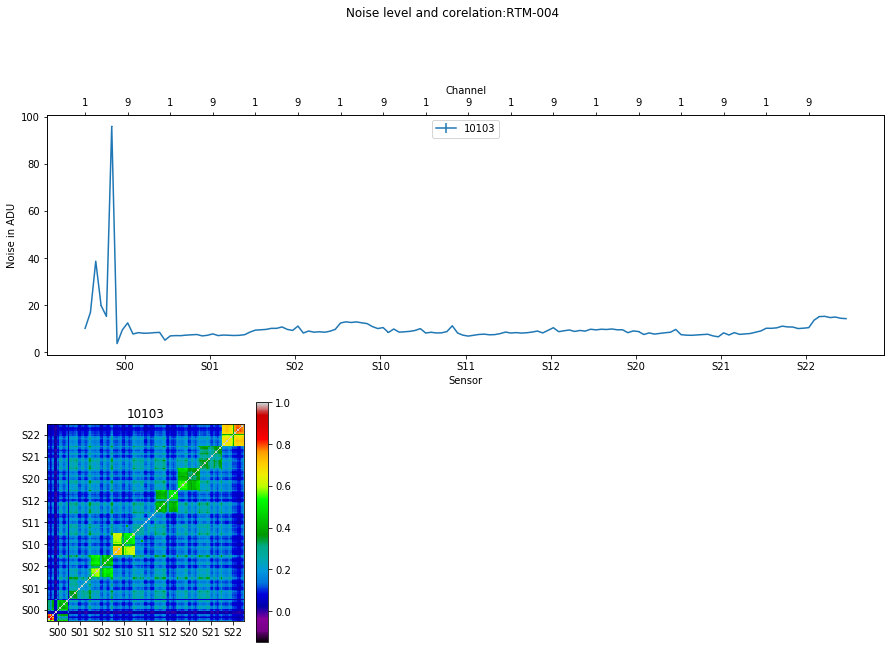

RTM-004_10103_all_noise.png


In [6]:
# compute the correlation between the # channels of the raft 
# It does only makes sens if 9 CCD per raft have been selected
if number_of_sensor !=9 : 
    print('Computing noise correlation inside raft works only for the full set of sensors (=9) ')
    raise
#
cornoise=np.zeros((number_of_run,144,144))
for irun in range(number_of_run) :
    for iccd in range(number_of_sensor) :
        for ch in range(16) :
            ff=all_file[irun,iccd]
            ch_cur=16*iccd+ch
            mean_over[irun,ch_cur]=ff[ch+1].data[100:1900,first_s_over+2:].mean(axis=1)
            if ch_cur%20==0 : print(ch_cur,' raft channels processed among 144')
            for iccd1 in range(number_of_sensor) :
                for ch1 in range(16) :
                    ch_cur1=16*iccd1+ch1
                    if ch_cur1 > ch_cur : continue
                    ff1=all_file[irun,iccd1]
                    cornoise[irun,ch_cur,ch_cur1]=np.array([(ff[ch+1].data[100:1900,i]-mean_over[irun,ch_cur][:])*(ff1[ch1+1].data[100:1900,i]-mean_over[irun,ch_cur1][:]) for i in range(first_s_over+2,ncol) ]).mean() 
for irun in range(number_of_run) :
    for iccd in range(number_of_sensor) :
        for ch in range(16) :
            ch_cur=16*iccd+ch
            for iccd1 in range(number_of_sensor) :
                for ch1 in range(16) :
                    ch_cur1=16*iccd1+ch1
                    if ch_cur1 > ch_cur :
                        cornoise[irun,ch_cur,ch_cur1]=cornoise[irun,ch_cur1,ch_cur]
cor=np.zeros((number_of_run,144,144))
for irun in range(number_of_run) :
    for iccd in range(number_of_sensor) :
        for ch in range(16) :
            ch_cur=16*iccd+ch
            #print(np.sqrt(cornoise[irun,ch_cur,ch_cur]),noise[irun,ch_cur])
            for iccd1 in range(number_of_sensor) :
                for ch1 in range(16) :
                    ch_cur1=16*iccd1+ch1
                    cor[irun,ch_cur,ch_cur1]=cornoise[irun,ch_cur,ch_cur1]/np.sqrt(cornoise[irun,ch_cur,ch_cur]*cornoise[irun,ch_cur1,ch_cur1])
# labels for the plots
label_txt=np.zeros((9),dtype=np.object_)
label_pos=np.zeros((9))
label_chan=np.zeros((18),dtype=np.object_)
label_chan_pos=np.zeros((18))
for  iccd in range(9) : 
        s=sensor_list[iccd]
        label_txt[iccd]=s
        label_pos[iccd]=iccd*16+7.5
        label_chan[iccd*2]='%d' % (1)
        label_chan[iccd*2+1]='%d' % (9)
        label_chan_pos[iccd*2]=iccd*16
        label_chan_pos[iccd*2+1]=iccd*16+8
# go for the plots
fig=plt.figure(figsize=[15,15])
fig.suptitle('Noise level and corelation:'+data_to_select['RTM'])

ax1=fig.add_subplot(3,1,1)
ax2=ax1.twiny()
#plt.tick_params(axis='x',top='on',labeltop='on')
#,bottom='off',labelbottom='off')
#
for irun in range(number_of_run) :
    ax1.errorbar(range(144),noise[irun,:],yerr=noise_std[irun,:],label=run_name_list[irun])
ax1.legend(loc=9)
ax1.set_ylabel('Noise in ADU')
ax1.set_xlabel('Sensor')
ax1.set_xticks(label_pos)
ax1.set_xticklabels(label_txt)
ax2.set_xlim(ax1.get_xlim())
ax2.tick_params(labeltop='on')
ax2.set_xticks(label_chan_pos)
ax2.set_xticklabels(label_chan)
plt.xlabel('Channel')
title=''
for irun in range(number_of_run) :
    loc=4+irun
    title+='_'+run_name_list[irun]
    fig.add_subplot(3,3,loc,title=run_name_list[irun])
    plt.imshow(cor[irun,:,:],cmap=matplotlib.cm.nipy_spectral,shape=(144,144),origin='lower',vmin=-.15,vmax=1.)
    plt.xticks(label_pos,label_txt)
    plt.yticks(label_pos,label_txt)
    plt.colorbar()
    #plt.show()
plt.show()
plotfile=data_to_select['RTM']+title+'_all_noise.png'
print (plotfile)
fig.savefig(plotfile,bbox_inches='tight')